# Shakespeare Genre Analysis: TF-IDF, Pearson Correlation, Syntactic Complexity
**IDS 570: Text as Data - Data Exploration**


## Research Question

To what extent do Shakespeare's genre categories (tragedy, comedy, history) correspond to measurable linguistic patterns in vocabulary, similarity structure, and syntactic complexity?



## Corpus

This corpus consists of **21 Shakespeare plays** from the Folger Digital Texts edition:

**Tragedies (8)**  
Hamlet, Macbeth, Othello, King Lear, Romeo and Juliet, Julius Caesar, Antony and Cleopatra, Coriolanus

**Comedies (8)**  
A Midsummer Night's Dream, Much Ado About Nothing, Twelfth Night, As You Like It, The Merchant of Venice, The Taming of the Shrew, The Comedy of Errors, The Tempest

**Histories (5)**  
Henry V, Richard III, Henry IV Part 1, Henry IV Part 2, Richard II

*All texts are drawn from the same editorial source to ensure consistency in formatting and transcription.*


## Methods

This analysis employs three complementary quantitative approaches:

1. **TF–IDF (Term Frequency–Inverse Document Frequency)**  
   Identifies lexically distinctive terms within each play relative to the full corpus.

2. **Pearson Correlation**  
   Measures pairwise similarity between plays based on shared vocabulary patterns.

3. **Syntactic Complexity Analysis**  
   Compares structural features (sentence length, clause density, subordination, coordination, and complex nominals) between selected plays using dependency parsing.


## Analytical Goal

Rather than assuming genre categories reflect inherent linguistic structure, this project evaluates whether quantitative textual evidence supports, complicates, or challenges traditional genre classifications. This exploratory approach treats genre as a hypothesis to be tested rather than a given.


## Setup & Imports

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
from collections import Counter

# NLP libraries
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

# Syntactic parsing
import spacy

# Settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline



/Users/shellyy/Desktop/570/Shakespeare-Text-Analysis/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(



## STEP 0: Load and Normalize Data


### Load Texts

In [2]:
data_path = Path("../Data/00_raw")

# Corpus structure
corpus_structure = {
    # Tragedies
    'hamlet_TXT_FolgerShakespeare.txt': ('Hamlet', 'tragedy'),
    'macbeth_TXT_FolgerShakespeare.txt': ('Macbeth', 'tragedy'),
    'othello_TXT_FolgerShakespeare.txt': ('Othello', 'tragedy'),
    'king-lear_TXT_FolgerShakespeare.txt': ('King Lear', 'tragedy'),
    'romeo-and-juliet_TXT_FolgerShakespeare.txt': ('Romeo and Juliet', 'tragedy'),
    'julius-caesar_TXT_FolgerShakespeare.txt': ('Julius Caesar', 'tragedy'),
    'antony-and-cleopatra_TXT_FolgerShakespeare.txt': ('Antony and Cleopatra', 'tragedy'),
    'coriolanus_TXT_FolgerShakespeare.txt': ('Coriolanus', 'tragedy'),

    # Comedies
    'a-midsummer-nights-dream_TXT_FolgerShakespeare.txt': ("A Midsummer Night's Dream", 'comedy'),
    'much-ado-about-nothing_TXT_FolgerShakespeare.txt': ('Much Ado About Nothing', 'comedy'),
    'twelfth-night_TXT_FolgerShakespeare.txt': ('Twelfth Night', 'comedy'),
    'as-you-like-it_TXT_FolgerShakespeare.txt': ('As You Like It', 'comedy'),
    'the-merchant-of-venice_TXT_FolgerShakespeare.txt': ('The Merchant of Venice', 'comedy'),
    'the-taming-of-the-shrew_TXT_FolgerShakespeare.txt': ('The Taming of the Shrew', 'comedy'),
    'the-comedy-of-errors_TXT_FolgerShakespeare.txt': ('The Comedy of Errors', 'comedy'),
    'the-tempest_TXT_FolgerShakespeare.txt': ('The Tempest', 'comedy'),

    # Histories
    'henry-v_TXT_FolgerShakespeare.txt': ('Henry V', 'history'),
    'richard-iii_TXT_FolgerShakespeare.txt': ('Richard III', 'history'),
    'henry-iv-part-1_TXT_FolgerShakespeare.txt': ('Henry IV Part 1', 'history'),
    'henry-iv-part-2_TXT_FolgerShakespeare.txt': ('Henry IV Part 2', 'history'),
    'richard-ii_TXT_FolgerShakespeare.txt': ('Richard II', 'history'),
}

# Load plays
plays = []

for filename, (title, genre) in corpus_structure.items():
    text = (data_path / filename).read_text(encoding="utf-8")
    plays.append({
        "play": title,
        "genre": genre,
        "text": text,
        "word_count": len(text.split())
    })

df_plays = pd.DataFrame(plays)

df_plays.head()

,play,genre,text,word_count
0,Hamlet,tragedy,Hamlet\nby William Shakespeare\nEdited by Barb...,32004
1,Macbeth,tragedy,Macbeth\nby William Shakespeare\nEdited by Bar...,18315
2,Othello,tragedy,Othello\nby William Shakespeare\nEdited by Bar...,27945
3,King Lear,tragedy,King Lear\nby William Shakespeare\nEdited by B...,27599
4,Romeo and Juliet,tragedy,Romeo and Juliet\nby William Shakespeare\nEdit...,25913


## Text Normalization

Because the corpus consists of Early Modern English texts, normalization need to be applied to balance textual consistency with preservation of linguistic structure.

###  Normalization Choices

To improve comparability across documents while preserving rhetorical content, the following preprocessing steps were applied:

- Long s (ſ) normalization
  All instances of the long s character (ſ) were replaced with standard modern "s" to prevent tokenization errors and artificial feature splitting (e.g., *ſin* vs *sin*).
- Removed editorial metadata preceding the start of the play (before *ACT 1*).
- Removed separator lines and formatting artifacts.
- Removed stage directions enclosed in brackets (e.g., `[Enter Barnardo]`).
- Removed ACT and SCENE headers.
- Removed speaker labels (e.g., `HAMLET`, `BARNARDO`) both as standalone lines and when preceding dialogue.
- Converted all text to lowercase.
- Standardized whitespace.

In [3]:
def normalize_text(text):

    # Remove metadata before ACT 1
    act_match = re.search(r'\bACT\s+1\b', text, re.IGNORECASE)
    if act_match:
        text = text[act_match.start():]

    # Remove separator lines
    text = re.sub(r'=+', '', text)

    # Remove stage directions
    text = re.sub(r'\[.*?\]', '', text)

    # Remove ACT and SCENE headers
    text = re.sub(r'^ACT\s+\d+.*$', '', text, flags=re.MULTILINE | re.IGNORECASE)
    text = re.sub(r'^SCENE\s+\d+.*$', '', text, flags=re.MULTILINE | re.IGNORECASE)

    # Remove standalone speaker lines (ALL CAPS, short)
    text = re.sub(r'^\s*[A-Z]{2,}(?:\s+[A-Z]{2,})*\s*$', '', text, flags=re.MULTILINE)

    # Remove speaker names at beginning of dialogue lines
    text = re.sub(r'^\s*[A-Z]{2,}(?:\s+[A-Z]{2,})*\s+', '', text, flags=re.MULTILINE)

    # Fix long s
    text = text.replace('ſ', 's')

    # Lowercase
    text = text.lower()

    # Clean whitespace
    text = re.sub(r'\n\s*\n+', '\n\n', text)
    text = re.sub(r' +', ' ', text)

    return text.strip()

# Re-apply normalization
df_plays["text_norm"] = df_plays["text"].apply(normalize_text)

# Check
print("Text Example After Normalization:")
print("")
print(df_plays.iloc[0]['text_norm'][:200])


Text Example After Normalization:

who's there?

nay, answer me. stand and unfold yourself.
long live the king!
barnardo?
he.

you come most carefully upon your hour.

'tis now struck twelve. get thee to bed, francisco.

for this relie


## STEP 1: TF-IDF Analysis

### Calculate TF-IDF

In [7]:
# Create TF-IDF vectorizer
# You can adjust these parameters:
tfidf = TfidfVectorizer(
    max_features=5000,        # Keep top 5000 features
    min_df=2,                 # Word must appear in at least 2 documents
    max_df=0.8,               # Word can't appear in more than 80% of documents
    stop_words='english',     # Remove common English stop words
    lowercase=True,
    token_pattern=r'\b[a-zA-Z]{3,}\b'  # Only words with 3+ letters
)

# Fit and transform
tfidf_matrix = tfidf.fit_transform(df_plays['text_norm'])
feature_names = tfidf.get_feature_names_out()

print(f"({tfidf_matrix.shape[0]} plays × {tfidf_matrix.shape[1]} features)")

(21 plays × 5000 features)


### Extract Top TF-IDF Terms per Play

In [14]:
def get_top_tfidf_terms(doc_index, n=15):
    tfidf_scores = tfidf_matrix[doc_index].toarray()[0]
    top_indices = tfidf_scores.argsort()[-n:][::-1]
    top_terms = [(feature_names[i], tfidf_scores[i]) for i in top_indices]
    return top_terms

# Get top terms for each play
top_terms_per_play = {}
for idx, row in df_plays.iterrows():
    top_terms_per_play[row['play']] = get_top_tfidf_terms(idx, n=15)

# Display results

print("TOP 15 TF-IDF TERMS PER PLAY")
print("=" * 80)
for play, terms in top_terms_per_play.items():
    genre = df_plays[df_plays['play'] == play]['genre'].values[0]
    print(f"\n{play} ({genre.upper()})")
    print("-" * 60)
    terms_str = ", ".join([f"{term}({score:.3f})" for term, score in terms])
    print(terms_str)

TOP 15 TF-IDF TERMS PER PLAY

Hamlet (TRAGEDY)
------------------------------------------------------------
norway(0.180), players(0.172), does(0.171), madness(0.160), england(0.153), marcellus(0.136), majesty(0.123), ghost(0.095), phrase(0.095), act(0.093), dane(0.090), uncle(0.080), carriages(0.075), priam(0.075), foils(0.075)

Macbeth (TRAGEDY)
------------------------------------------------------------
does(0.210), hail(0.201), scotland(0.179), tyrant(0.152), wood(0.137), deed(0.131), knock(0.130), daggers(0.112), kings(0.106), knocking(0.105), ross(0.104), sisters(0.098), highness(0.087), soldiers(0.085), castle(0.084)

Othello (TRAGEDY)
------------------------------------------------------------
moor(0.531), roderigo(0.299), handkerchief(0.288), cyprus(0.237), emilia(0.206), lieutenant(0.179), general(0.150), willow(0.142), venice(0.135), michael(0.102), signior(0.080), whore(0.078), prithee(0.077), strumpet(0.074), does(0.074)

King Lear (TRAGEDY)
-----------------------------

### Create TF-IDF Summary Table

In [ ]:
# Create a clean table for your report
tfidf_summary = []
for play, terms in top_terms_per_play.items():
    genre = df_plays[df_plays['play'] == play]['genre'].values[0]
    top_words = ", ".join([term for term, score in terms[:10]])
    tfidf_summary.append({
        'Play': play,
        'Genre': genre,
        'Top 10 Distinctive Terms': top_words
    })

df_tfidf_summary = pd.DataFrame(tfidf_summary)
print(df_tfidf_summary.to_string(index=False))

# Save to CSV
df_tfidf_summary.to_csv('tfidf_results.csv', index=False)

                     Play   Genre                                                                     Top 5 Distinctive Terms
                   Hamlet tragedy             norway, players, does, madness, england, marcellus, majesty, ghost, phrase, act
                  Macbeth tragedy                   does, hail, scotland, tyrant, wood, deed, knock, daggers, kings, knocking
                  Othello tragedy  moor, roderigo, handkerchief, cyprus, emilia, lieutenant, general, willow, venice, michael
                King Lear tragedy             edmund, gloucester, kent, tom, daughters, france, burgundy, letter, dover, gods
         Romeo and Juliet tragedy               nurse, paris, friar, county, mantua, thursday, banished, verona, cell, cousin
            Julius Caesar tragedy          caesar, brutus, cassius, antony, rome, octavius, lucius, capitol, romans, philippi
     Antony and Cleopatra tragedy                antony, caesar, cleopatra, egypt, pompey, lepidus, agrippa, rome, god

## TF-IDF Interpretation

### 1. Do some documents share distinctive vocabulary?

Yes. Several documents share distinctive vocabulary, particularly within the same genre and historical context.

**Within Tragedies:**
- Roman plays share political vocabulary: *Julius Caesar*, *Antony and Cleopatra*, and *Coriolanus* all feature "caesar," "rome," and political titles ("general," "senate," "capitol")
- English historical tragedies share geographic terms: *Hamlet* ("norway," "england"), *Macbeth* ("scotland")
- Domestic tragedies share family/relationship terms: *Othello* and *King Lear* include relationship markers ("lieutenant," "daughters," "kent")

**Within Comedies:**
- Romantic comedies share terms of courtship and social hierarchy: "duke," "count," "prince" appear across *Twelfth Night*, *As You Like It*, and *Much Ado About Nothing*
- Italian comedies share geographic vocabulary: *The Merchant of Venice* ("venice," "ducats"), *The Taming of the Shrew* ("padua," "signior"), *The Comedy of Errors* ("ducats," "merchant")
- Pastoral/magical comedies: *A Midsummer Night's Dream* ("fairy," "wood," "athens") and *The Tempest* ("island," "monster") share fantastical settings

**Within Histories:**
- All histories share aristocratic titles and English geography: "duke," "prince," "york," "john"
- The Henry IV plays are particularly close, both featuring "falstaff," "harry," "prince," "john," "bardolph"

**Cross-genre patterns:**
- Religious language appears inconsistently: "friar" (*Romeo and Juliet*, *Much Ado About Nothing*), "gods" (*King Lear*, *Antony and Cleopatra*, *Coriolanus*)
- The interrogative "does" appears in multiple tragedies (*Hamlet*, *Macbeth*, *Twelfth Night*), possibly reflecting rhetorical questioning

### 2. Are distinctive terms topical, rhetorical, or technical?

**Predominantly topical, with some rhetorical elements:**

The distinctive terms are mostly topical and character-driven, with some rhetorical.

**Topical (majority):**
- **Character names dominate**: Nearly every play's distinctive vocabulary is character-driven (*Hamlet*: "marcellus," "ghost"; *Othello*: "roderigo," "emilia"; *Romeo and Juliet*: "nurse," "friar"). This reflects Shakespeare's character-centric dramaturgy.
- **Geographic specificity**: Place names establish setting (*Othello*: "cyprus," "venice"; *Macbeth*: "scotland"; *Julius Caesar*: "rome," "philippi")
- **Plot-specific objects**: Key props appear as distinctive terms (*Othello*: "handkerchief"; *Macbeth*: "daggers"; *The Comedy of Errors*: "chain," "rope"; *The Merchant of Venice*: "bond")

**Rhetorical (limited):**
- The appearance of "does" in *Hamlet*, *Macbeth*, and *Twelfth Night* may indicate rhetorical questioning patterns
- *Hamlet*'s "phrase" and "act" suggest metatheatrical or philosophical discourse
- Forms of address vary by genre: "signior" (Italian comedies), "majesty" (English histories/tragedies)

**Technical:**
- Military/political titles: "lieutenant," "general," "capitol," "senate"
- Legal/commercial terms: "ducats," "bond," "merchant," "clerk," "judge"

**Key insight**: TF-IDF here primarily captures **what makes each play's world unique** (its cast of characters, setting, and central objects) rather than distinctive rhetorical strategies. This suggests Shakespeare's lexical variation operates more at the level of dramatic world-building than at stylistic differentiation.



### 3. Are there documents whose distinctiveness seems driven by noise or formatting?

There is little evidence of formatting noise in the results.

- Character labels appear to have been successfully removed.
- Stage directions do not dominate.
- No artifacts like "ACT" or "SCENE" appear.
- No OCR distortions or stray punctuation dominate.

Some generic verbs like *does* appear in multiple tragedies, but this is likely due to contextual emphasis rather than preprocessing error.

Overall, the TF-IDF output appears clean and substantively meaningful.

But for more refined lexical analysis, we might:
1. Remove character names systematically
2. Verify that stage directions are fully removed
3. Standardize archaic verb forms ("does"/"doth")
4. Consider lemmatization to group inflected forms

---
## STEP 2: Pearson Correlation Analysis

### Calculate Pairwise Correlations

In [21]:
# Convert TF-IDF matrix to dense array
tfidf_dense = tfidf_matrix.toarray()

# Calculate Pearson correlation matrix
correlation_matrix = np.corrcoef(tfidf_dense)

# Create DataFrame with play names
df_corr = pd.DataFrame(
    correlation_matrix,
    index=df_plays['play'],
    columns=df_plays['play']
)

# Round for readability
df_corr = df_corr.round(3)

print("Correlation matrix shape:", df_corr.shape)
print("\nFirst 5x5 subset:")
print(df_corr.iloc[:5, :5])

Correlation matrix shape: (21, 21)

First 5x5 subset:
play              Hamlet  Macbeth  Othello  King Lear  Romeo and Juliet
play                                                                   
Hamlet             1.000    0.150    0.073      0.064             0.032
Macbeth            0.150    1.000    0.037      0.087             0.022
Othello            0.073    0.037    1.000      0.037            -0.000
King Lear          0.064    0.087    0.037      1.000             0.022
Romeo and Juliet   0.032    0.022   -0.000      0.022             1.000


### Create Similarity Heatmap

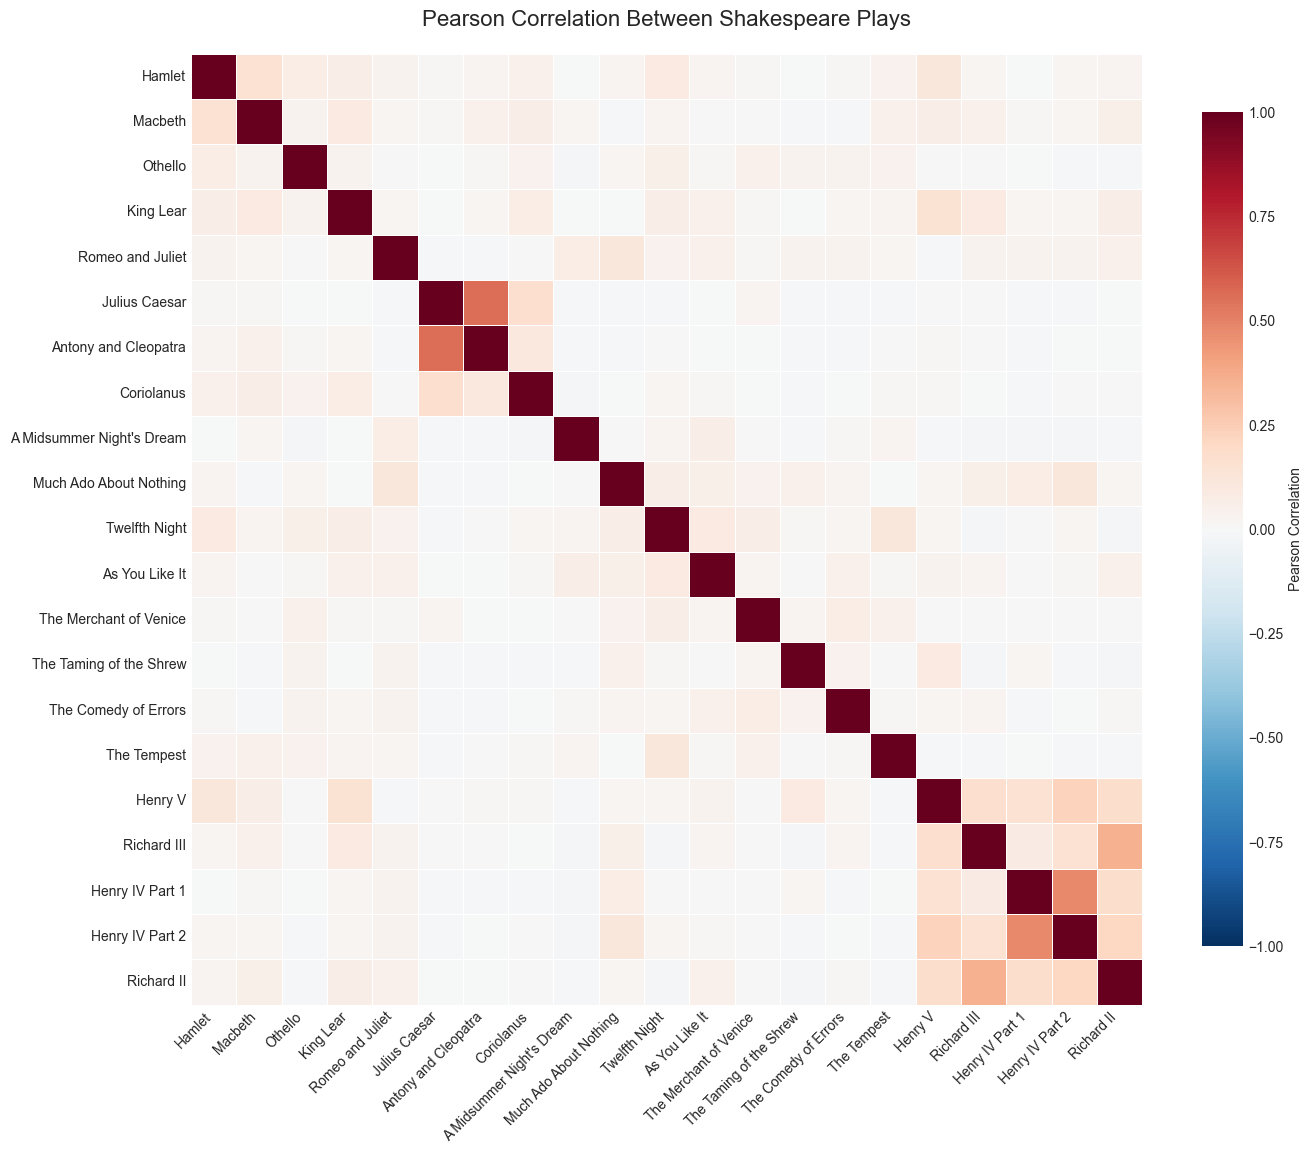

In [22]:
# Create heatmap
plt.figure(figsize=(14, 12))

# Create heatmap with better color scheme
sns.heatmap(
    df_corr,
    cmap='RdBu_r',           # Red-Blue diverging colormap
    center=0,                # Center at 0
    vmin=-1, vmax=1,         # Correlation range
    square=True,             # Square cells
    linewidths=0.5,          # Grid lines
    cbar_kws={"shrink": 0.8, "label": "Pearson Correlation"},
    annot=False              # Set to True if you want numbers in cells
)

plt.title('Pearson Correlation Between Shakespeare Plays', fontsize=16, pad=20)
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Save figure
plt.savefig('pearson_heatmap.png', dpi=300, bbox_inches='tight')

plt.show()

### Find Most and Least Similar Pairs

In [ ]:
# Get upper triangle (to avoid duplicates and diagonal)
mask = np.triu(np.ones_like(df_corr), k=1).astype(bool)
corr_values = df_corr.where(mask)

# Convert to long format
corr_long = corr_values.stack().reset_index()
corr_long.columns = ['Play_1', 'Play_2', 'Correlation']

# Sort by correlation
corr_sorted = corr_long.sort_values('Correlation', ascending=False)

# Most similar pairs
print("=" * 80)
print("TOP 5 MOST SIMILAR PLAY PAIRS")
print("=" * 80)
for idx, row in corr_sorted.head(5).iterrows():
    genre1 = df_plays[df_plays['play'] == row['Play_1']]['genre'].values[0]
    genre2 = df_plays[df_plays['play'] == row['Play_2']]['genre'].values[0]
    print(f"{row['Play_1']} ({genre1}) <--> {row['Play_2']} ({genre2})")
    print(f"  Correlation: {row['Correlation']:.3f}")
    print()

# Least similar pairs
print("=" * 80)
print("TOP 5 LEAST SIMILAR PLAY PAIRS")
print("=" * 80)
for idx, row in corr_sorted.tail(5).iterrows():
    genre1 = df_plays[df_plays['play'] == row['Play_1']]['genre'].values[0]
    genre2 = df_plays[df_plays['play'] == row['Play_2']]['genre'].values[0]
    print(f"{row['Play_1']} ({genre1}) <--> {row['Play_2']} ({genre2})")
    print(f"  Correlation: {row['Correlation']:.3f}")
    print()

ValueError: cannot insert play, already exists

### Pearson Correlation Interpretation

**Required answers:**

1. **Two most similar document pairs:**
   - [Your answer here]

2. **Two least similar document pairs:**
   - [Your answer here]

3. **What questions would you ask from this corpus after seeing these patterns?**
   - [Your answer here]

---
## STEP 3: Syntactic Complexity Analysis

### Select Two Plays for Comparison

**Based on your TF-IDF and Pearson results, choose 2 plays to compare**

In [ ]:
# UPDATE THESE WITH YOUR CHOSEN PLAYS!
play1_name = "Hamlet"  # Replace with actual play name
play2_name = "Twelfth Night"  # Replace with actual play name

# Get texts
play1_text = df_plays[df_plays['play'] == play1_name]['text'].values[0]
play2_text = df_plays[df_plays['play'] == play2_name]['text'].values[0]

print(f"Selected plays for syntactic analysis:")
print(f"  Play 1: {play1_name}")
print(f"  Play 2: {play2_name}")
print(f"\nReason for selection: [WRITE YOUR REASONING HERE]")

### Load Spacy Model for Syntactic Parsing

In [ ]:
# Load spaCy English model
# If not installed, run: python -m spacy download en_core_web_sm
try:
    nlp = spacy.load("en_core_web_sm")
    print("✓ Spacy model loaded successfully")
except:
    print("Please install spacy model:")
    print("  python -m spacy download en_core_web_sm")
    raise

# For large texts, increase max_length
nlp.max_length = 2000000  # Increase as needed

### Define Syntactic Complexity Functions

In [ ]:
def calculate_syntactic_complexity(text, play_name):
    """
    Calculate syntactic complexity measures for a text
    
    Returns:
    - Mean Length of Sentence (MLS)
    - Clauses per Sentence (C/S)
    - Dependent Clauses per Sentence
    - Coordination per Sentence
    - Complex Nominals per Sentence
    """
    print(f"Parsing {play_name}... (this may take a few minutes)")
    
    # Parse text
    doc = nlp(text[:500000])  # Limit to first 500k chars if needed
    
    # Initialize counters
    sentences = list(doc.sents)
    n_sentences = len(sentences)
    
    total_words = 0
    total_clauses = 0
    total_dependent_clauses = 0
    total_coordination = 0
    total_complex_nominals = 0
    
    for sent in sentences:
        # Word count
        words = [token for token in sent if not token.is_punct]
        total_words += len(words)
        
        # Clause count (simplified: count verbs)
        verbs = [token for token in sent if token.pos_ == "VERB"]
        total_clauses += len(verbs)
        
        # Dependent clauses (advcl, acl, ccomp, xcomp)
        dep_clauses = [token for token in sent if token.dep_ in ['advcl', 'acl', 'ccomp', 'xcomp']]
        total_dependent_clauses += len(dep_clauses)
        
        # Coordination (conj)
        coord = [token for token in sent if token.dep_ == 'conj']
        total_coordination += len(coord)
        
        # Complex nominals (noun with modifiers)
        nouns_with_mods = [token for token in sent if token.pos_ == 'NOUN' and 
                          any(child.dep_ in ['amod', 'nmod', 'acl', 'relcl'] for child in token.children)]
        total_complex_nominals += len(nouns_with_mods)
    
    # Calculate measures
    results = {
        'play': play_name,
        'sentences': n_sentences,
        'MLS': total_words / n_sentences if n_sentences > 0 else 0,
        'C/S': total_clauses / n_sentences if n_sentences > 0 else 0,
        'DC/S': total_dependent_clauses / n_sentences if n_sentences > 0 else 0,
        'Coord/S': total_coordination / n_sentences if n_sentences > 0 else 0,
        'CN/S': total_complex_nominals / n_sentences if n_sentences > 0 else 0
    }
    
    print(f"✓ Parsing complete for {play_name}")
    return results, doc

print("✓ Syntactic complexity functions defined")

### Calculate Complexity for Both Plays

**WARNING**: This may take 5-10 minutes per play!

In [ ]:
# Calculate for Play 1
results1, doc1 = calculate_syntactic_complexity(play1_text, play1_name)

# Calculate for Play 2
results2, doc2 = calculate_syntactic_complexity(play2_text, play2_name)

print("\n✓ Syntactic analysis complete for both plays!")

### Create Summary Table

In [ ]:
# Create comparison table
df_syntax = pd.DataFrame([results1, results2])
df_syntax = df_syntax.set_index('play')

# Format for display
df_syntax_display = df_syntax.copy()
for col in ['MLS', 'C/S', 'DC/S', 'Coord/S', 'CN/S']:
    df_syntax_display[col] = df_syntax_display[col].round(2)

print("=" * 80)
print("SYNTACTIC COMPLEXITY COMPARISON")
print("=" * 80)
print(df_syntax_display.to_string())
print("\nMeasures:")
print("  MLS = Mean Length of Sentence")
print("  C/S = Clauses per Sentence")
print("  DC/S = Dependent Clauses per Sentence")
print("  Coord/S = Coordination per Sentence")
print("  CN/S = Complex Nominals per Sentence")

# Save to CSV
df_syntax_display.to_csv('syntactic_complexity.csv')
print("\n✓ Saved to syntactic_complexity.csv")

### Visualize Syntactic Differences

In [ ]:
# Create bar chart comparison
fig, ax = plt.subplots(figsize=(12, 6))

measures = ['MLS', 'C/S', 'DC/S', 'Coord/S', 'CN/S']
x = np.arange(len(measures))
width = 0.35

play1_values = [results1[m] for m in measures]
play2_values = [results2[m] for m in measures]

ax.bar(x - width/2, play1_values, width, label=play1_name, alpha=0.8)
ax.bar(x + width/2, play2_values, width, label=play2_name, alpha=0.8)

ax.set_xlabel('Measure', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
ax.set_title('Syntactic Complexity Comparison', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(measures)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('syntactic_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Saved chart to syntactic_comparison.png")
plt.show()

### Extract Example Sentences

In [ ]:
def find_example_sentence(doc, play_name, criterion='longest'):
    """
    Find an example sentence based on criterion
    
    criterion: 'longest', 'most_complex', 'most_coordination'
    """
    sentences = list(doc.sents)
    
    if criterion == 'longest':
        # Find longest sentence
        sent = max(sentences, key=lambda s: len([t for t in s if not t.is_punct]))
    elif criterion == 'most_complex':
        # Find sentence with most dependent clauses
        sent = max(sentences, key=lambda s: len([t for t in s if t.dep_ in ['advcl', 'acl', 'ccomp', 'xcomp']]))
    elif criterion == 'most_coordination':
        # Find sentence with most coordination
        sent = max(sentences, key=lambda s: len([t for t in s if t.dep_ == 'conj']))
    
    return sent.text.strip()

# Get example sentences
print("=" * 80)
print("EXAMPLE SENTENCES")
print("=" * 80)

print(f"\n{play1_name} - Longest Sentence:")
print("-" * 60)
example1 = find_example_sentence(doc1, play1_name, 'longest')
print(example1[:500] + "..." if len(example1) > 500 else example1)

print(f"\n{play2_name} - Longest Sentence:")
print("-" * 60)
example2 = find_example_sentence(doc2, play2_name, 'longest')
print(example2[:500] + "..." if len(example2) > 500 else example2)

print(f"\n{play1_name} - Most Complex (dependent clauses):")
print("-" * 60)
example3 = find_example_sentence(doc1, play1_name, 'most_complex')
print(example3[:500] + "..." if len(example3) > 500 else example3)

print(f"\n{play2_name} - Most Complex (dependent clauses):")
print("-" * 60)
example4 = find_example_sentence(doc2, play2_name, 'most_complex')
print(example4[:500] + "..." if len(example4) > 500 else example4)

### Syntactic Complexity Interpretation

**Required answers:**

1. **How do the two texts differ in syntactic complexity?**
   - [Your answer here]

2. **Do these differences align with or complicate your earlier lexical findings?**
   - [Your answer here]

3. **What kinds of rhetorical or stylistic practices might these syntactic patterns reflect?**
   - [Your answer here]

---
## STEP 4: SYNTHESIS

### Triangulating Evidence Across All Three Approaches

**This is the most important section!**

Articulate one central analytical question/hypothesis that draws on:
- TF-IDF evidence
- Pearson similarity/distance evidence  
- Syntactic complexity evidence

---

### Central Question/Hypothesis:

[WRITE YOUR CENTRAL QUESTION HERE]

Example: "Do Shakespeare's genre categories (tragedy, comedy, history) reflect measurable linguistic patterns, or are they primarily thematic/plot-based distinctions?"

---

### Evidence from TF-IDF:

[SUMMARIZE KEY FINDINGS FROM TF-IDF]

Example:
- Tragedies share vocabulary related to death, blood, revenge, fate
- Comedies share vocabulary related to love, marriage, jest, disguise
- Character names dominate distinctive terms

---

### Evidence from Pearson Correlation:

[SUMMARIZE KEY FINDINGS FROM CORRELATION ANALYSIS]

Example:
- Strong within-genre clustering (tragedies correlate with tragedies)
- Clear separation between tragedy and comedy
- BUT some plays bridge categories (e.g., Merchant of Venice)
- Histories form distinct cluster

---

### Evidence from Syntactic Complexity:

[SUMMARIZE KEY FINDINGS FROM SYNTAX ANALYSIS]

Example:
- Hamlet shows higher complexity: longer sentences, more subordination
- Twelfth Night shows simpler structures: coordination, shorter sentences
- Syntactic differences align with lexical differences

---

### Conclusion:

[YOUR SYNTHESIS AND CONCLUSIONS]

Example:
"Shakespeare's genres are computationally distinguishable across multiple dimensions. Tragedies and comedies differ not only in vocabulary (what they discuss) but in syntax (how they construct arguments). However, problem plays and late romances resist clean classification, suggesting genre exists on a spectrum rather than as rigid categories. This analysis demonstrates that computational methods can illuminate both the coherence of traditional genre labels and their limitations."

---
## Summary of Outputs

### Files Generated:
1. `tfidf_results.csv` - Top TF-IDF terms per play
2. `pearson_heatmap.png` - Correlation heatmap
3. `syntactic_complexity.csv` - Complexity measures
4. `syntactic_comparison.png` - Bar chart comparison

### For Your Report:
- Include all visualizations
- Reference tables in your analysis
- Answer all interpretive questions
- Write synthesis section

### For Canvas Submission:
- Post this notebook to GitHub
- Include link in Discussion Board post
- Upload all PNG files
- Write your report with interpretations

---
## Notes & Reflections

[Use this space for any additional notes, observations, or ideas that emerged during your analysis]